# Xgboost Algorithm
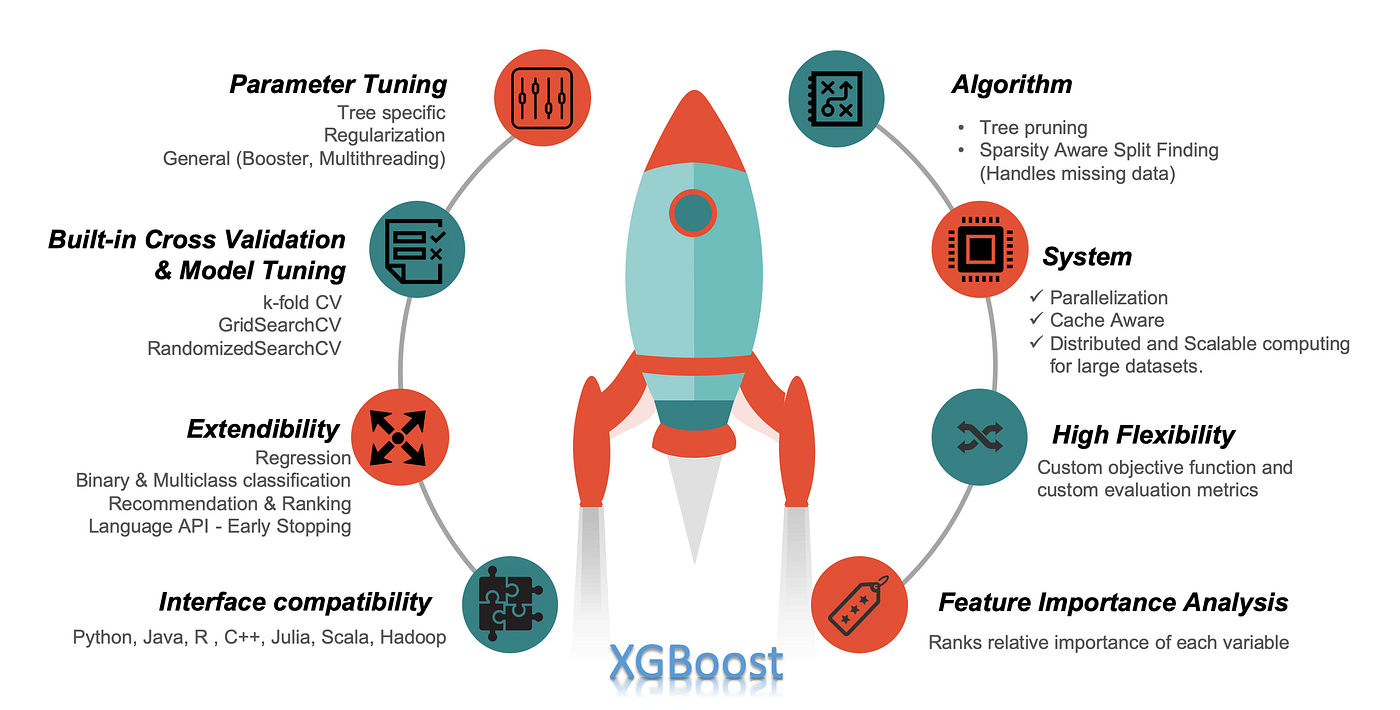

In [1]:
%pip install xgboost


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

### Step 1: Read the train dataset

In [3]:
import pandas as pd
df = pd.read_csv("train_weather.csv")
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


### Step 2: Perform basic data quality checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()

Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
# Remove the duplicates
df = df.drop_duplicates(keep="first")

### Step 3 - Seperating X and Y

In [8]:
X = df.drop(columns=['Weather Type'])
Y = df[['Weather Type']]

In [9]:
X.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


In [10]:
Y.head()

,Weather Type
0,Rainy
1,Cloudy
2,Sunny
3,Sunny
4,Rainy


In [11]:
Y.value_counts()

Weather Type
Cloudy          3300
Rainy           3300
Snowy           3300
Sunny           3300
Name: count, dtype: int64

### Preprocess X and Y
Applicable to only xgboost - Also need to label encode Y variable

In [12]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [15]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

In [16]:
pre = ColumnTransformer(
    [
        ('num', num_pipe, con),
        ('cat', cat_pipe, cat)
    ]
).set_output(transform='pandas')

In [17]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-0.294931,0.212404,-0.048086,0.887629,0.134203,-0.520104,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.143035,1.351385,-0.192836,0.543291,0.150602,0.776424,1.345768,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.625367,-0.233285,-0.409962,-1.178401,0.346579,0.257813,0.010999,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.085516,0.707613,-1.206089,0.887629,0.549008,0.776424,-1.323769,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.452811,0.261924,1.037543,0.386773,-0.407490,-0.779410,-0.878846,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Label encode Y features

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_pre = le.fit_transform(Y)

In [20]:
Y_pre[0:5]

array([1, 0, 3, 3, 1])

### Step 4 : Train test split

In [22]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y_pre, test_size=0.2, random_state=42)

In [23]:
xtrain.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
3958,0.740404,-0.134243,-0.554712,1.200664,0.117804,-0.520104,-1.175461,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2239,-0.237413,1.351385,0.169040,0.105042,0.299802,-1.038715,-0.433923,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3608,0.510330,-0.530410,-0.482337,-1.334918,0.525351,1.554340,1.049153,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6848,1.603184,0.757134,5.018179,0.981540,-0.364746,-0.520104,-1.027154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
6119,-0.064857,-0.134243,0.603291,-1.366221,-0.155596,-0.779410,0.752538,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [25]:
ytrain[0:5]

array([1, 1, 3, 1, 0])

In [26]:
xtest.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
4111,0.222737,-1.520829,-0.771838,-1.491435,0.412980,1.295035,1.345768,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
10607,2.465964,1.252343,0.675666,0.918933,0.530728,1.554340,-0.433923,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7372,1.200553,-0.877057,-1.133714,-1.303614,0.519437,1.035729,0.752538,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
11786,-1.502823,0.509529,-0.482337,1.138057,-0.329798,-1.038715,-1.175461,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
12227,0.107699,1.252343,0.024290,1.732823,0.588257,1.813646,1.049153,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [27]:
ytest[0:5]

array([3, 3, 3, 2, 3])

In [30]:
xtrain.shape

(10560, 18)

In [31]:
xtest.shape

(2640, 18)

### Build the model

In [33]:
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators = 300,
    max_depth = 3
)
model.fit(xtrain, ytrain, eval_set = [(xtest, ytest)], verbose=True)

[0]	validation_0-mlogloss:0.97147
[1]	validation_0-mlogloss:0.73961
[2]	validation_0-mlogloss:0.59453
[3]	validation_0-mlogloss:0.49711
[4]	validation_0-mlogloss:0.42963
[5]	validation_0-mlogloss:0.37995
[6]	validation_0-mlogloss:0.34550
[7]	validation_0-mlogloss:0.31773
[8]	validation_0-mlogloss:0.29676
[9]	validation_0-mlogloss:0.28140
[10]	validation_0-mlogloss:0.27045
[11]	validation_0-mlogloss:0.26128
[12]	validation_0-mlogloss:0.25350
[13]	validation_0-mlogloss:0.24705
[14]	validation_0-mlogloss:0.24239
[15]	validation_0-mlogloss:0.23729
[16]	validation_0-mlogloss:0.23383
[17]	validation_0-mlogloss:0.22940
[18]	validation_0-mlogloss:0.22719
[19]	validation_0-mlogloss:0.22441
[20]	validation_0-mlogloss:0.22247
[21]	validation_0-mlogloss:0.22027
[22]	validation_0-mlogloss:0.22021
[23]	validation_0-mlogloss:0.21890
[24]	validation_0-mlogloss:0.21854
[25]	validation_0-mlogloss:0.21761
[26]	validation_0-mlogloss:0.21682
[27]	validation_0-mlogloss:0.21576
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [36]:
model.evals_result()

{'validation_0': OrderedDict([('mlogloss',
               [0.9714687358475093,
                0.7396058283068917,
                0.59452825304911,
                0.4971126744692976,
                0.4296309894289483,
                0.3799471796857137,
                0.34549570370917065,
                0.3177328184049464,
                0.29675599315457724,
                0.28140334335692,
                0.27045294601526676,
                0.2612778898420264,
                0.25350001258070043,
                0.24704522466160017,
                0.24238554518669844,
                0.2372895737940615,
                0.23383175012634388,
                0.22940060341833018,
                0.22719335747886252,
                0.2244101086138416,
                0.2224712858256129,
                0.22027480588153456,
                0.22021482861292138,
                0.21889935916370826,
                0.21854477096013866,
                0.21760723196379275,
           

In [40]:
loss = model.evals_result()['validation_0']['mlogloss']
loss

[0.9714687358475093,
 0.7396058283068917,
 0.59452825304911,
 0.4971126744692976,
 0.4296309894289483,
 0.3799471796857137,
 0.34549570370917065,
 0.3177328184049464,
 0.29675599315457724,
 0.28140334335692,
 0.27045294601526676,
 0.2612778898420264,
 0.25350001258070043,
 0.24704522466160017,
 0.24238554518669844,
 0.2372895737940615,
 0.23383175012634388,
 0.22940060341833018,
 0.22719335747886252,
 0.2244101086138416,
 0.2224712858256129,
 0.22027480588153456,
 0.22021482861292138,
 0.21889935916370826,
 0.21854477096013866,
 0.21760723196379275,
 0.21681745835973715,
 0.2157563761843476,
 0.21554097914587614,
 0.21590052267616336,
 0.2156463017558439,
 0.2151405417747204,
 0.21453236675852994,
 0.2148373668615408,
 0.21492327418042503,
 0.21448678124687637,
 0.21462988985482354,
 0.21483973114891067,
 0.21461808051881234,
 0.21453615348452854,
 0.2145088143365876,
 0.21452067214398113,
 0.2144590990867183,
 0.21400383721763566,
 0.21387806094712272,
 0.21405819719096172,
 0.2138053

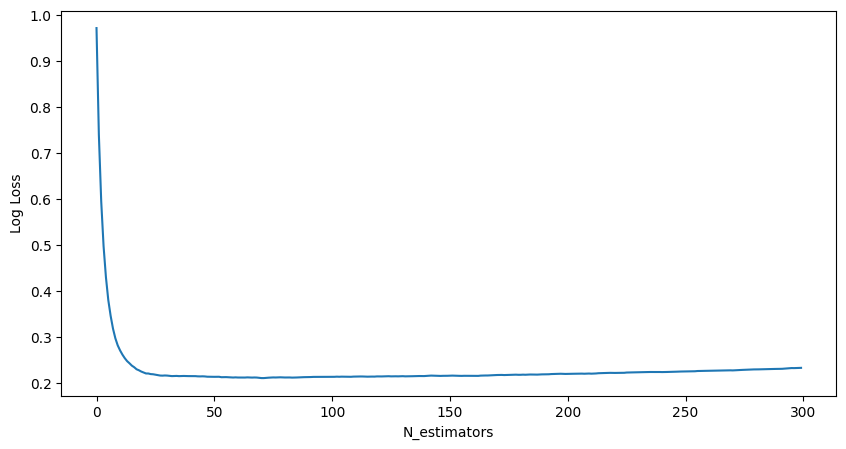

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.xlabel("N_estimators")
plt.ylabel("Log Loss")
plt.show()

In [42]:
model.score(xtrain, ytrain)

0.9961174242424242

In [43]:
model.score(xtest, ytest)

0.9128787878787878

### Always check cross validated F1 Macro Score

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, xtrain, ytrain, cv=5, scoring='f1_macro')
scores

array([0.91911932, 0.9086168 , 0.90742918, 0.91393434, 0.92101424])

In [45]:
scores.mean()

np.float64(0.9140227744821485)

### Feature importance

In [48]:
model.feature_importances_

array([0.08042917, 0.00592751, 0.0063642 , 0.0395065 , 0.0220015 ,
       0.07620671, 0.03669349, 0.6053045 , 0.01309693, 0.02138668,
       0.00768963, 0.00563845, 0.0039    , 0.00299883, 0.05730655,
       0.00820474, 0.00275087, 0.00459381], dtype=float32)

In [47]:
xtrain.columns

Index(['num__Temperature', 'num__Humidity', 'num__Wind Speed',
       'num__Precipitation (%)', 'num__Atmospheric Pressure', 'num__UV Index',
       'num__Visibility (km)', 'cat__Cloud Cover_clear',
       'cat__Cloud Cover_cloudy', 'cat__Cloud Cover_overcast',
       'cat__Cloud Cover_partly cloudy', 'cat__Season_Autumn',
       'cat__Season_Spring', 'cat__Season_Summer', 'cat__Season_Winter',
       'cat__Location_coastal', 'cat__Location_inland',
       'cat__Location_mountain'],
      dtype='object')

In [50]:
imp = pd.Series(
    model.feature_importances_,
    index = xtrain.columns
)
imp

num__Temperature                  0.080429
num__Humidity                     0.005928
num__Wind Speed                   0.006364
num__Precipitation (%)            0.039506
num__Atmospheric Pressure         0.022001
num__UV Index                     0.076207
num__Visibility (km)              0.036693
cat__Cloud Cover_clear            0.605304
cat__Cloud Cover_cloudy           0.013097
cat__Cloud Cover_overcast         0.021387
cat__Cloud Cover_partly cloudy    0.007690
cat__Season_Autumn                0.005638
cat__Season_Spring                0.003900
cat__Season_Summer                0.002999
cat__Season_Winter                0.057307
cat__Location_coastal             0.008205
cat__Location_inland              0.002751
cat__Location_mountain            0.004594
dtype: float32

In [51]:
imp.sort_values(ascending=False)

cat__Cloud Cover_clear            0.605304
num__Temperature                  0.080429
num__UV Index                     0.076207
cat__Season_Winter                0.057307
num__Precipitation (%)            0.039506
num__Visibility (km)              0.036693
num__Atmospheric Pressure         0.022001
cat__Cloud Cover_overcast         0.021387
cat__Cloud Cover_cloudy           0.013097
cat__Location_coastal             0.008205
cat__Cloud Cover_partly cloudy    0.007690
num__Wind Speed                   0.006364
num__Humidity                     0.005928
cat__Season_Autumn                0.005638
cat__Location_mountain            0.004594
cat__Season_Spring                0.003900
cat__Season_Summer                0.002999
cat__Location_inland              0.002751
dtype: float32

In [52]:
imp.sort_values(ascending=False).sum()

np.float32(1.0)

<Axes: >

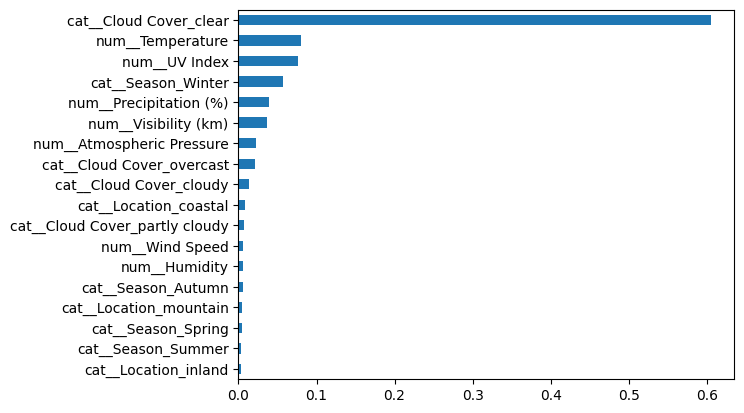

In [53]:
imp.sort_values().plot(kind='barh')

### Step 6 : Model Evaluation

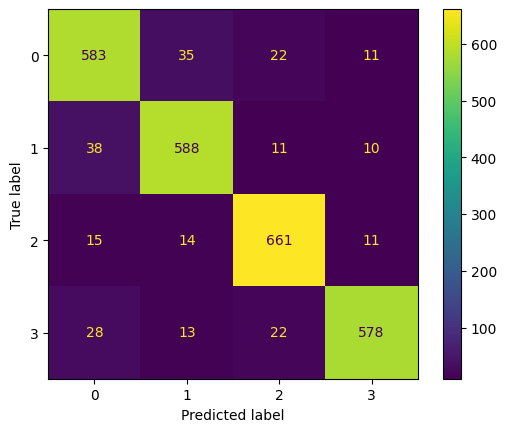

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, xtest, ytest)

In [56]:
ypred_train = model.predict(xtrain)
ypred_test = model.predict(xtest)

In [57]:
ytrain[0:5]

array([1, 1, 3, 1, 0])

In [58]:
ypred_train[0:5]

array([1, 1, 3, 1, 0])

In [60]:
ytest[0:5]

array([3, 3, 3, 2, 3])

In [59]:
ypred_test[0:5]

array([3, 3, 3, 2, 3])

In [61]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_test))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       651
           1       0.90      0.91      0.91       647
           2       0.92      0.94      0.93       701
           3       0.95      0.90      0.92       641

    accuracy                           0.91      2640
   macro avg       0.91      0.91      0.91      2640
weighted avg       0.91      0.91      0.91      2640



### Because model has f1_macro = 0.91 > 0.8 hence model is very good

### Step 7: Out of Sample Prediction

In [62]:
xnew = pd.read_csv('test_weather.csv')
xnew.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland


In [63]:
pre

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Temperature', 'Humidity', 'Wind Speed',
                                  'Precipitation (%)', 'Atmospheric Pressure',
                                  'UV Index', 'Visibility (km)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Cloud Cover', 'Season', 'Location'])])

In [64]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Temperature,num__Humidity,num__Wind Speed,num__Precipitation (%),num__Atmospheric Pressure,num__UV Index,num__Visibility (km),cat__Cloud Cover_clear,cat__Cloud Cover_cloudy,cat__Cloud Cover_overcast,cat__Cloud Cover_partly cloudy,cat__Season_Autumn,cat__Season_Spring,cat__Season_Summer,cat__Season_Winter,cat__Location_coastal,cat__Location_inland,cat__Location_mountain
0,-1.100192,-0.035201,0.892792,0.386773,-0.561530,-1.038715,-1.027154,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,5.054302,1.896115,0.748042,0.918933,0.246574,1.813646,0.455922,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.007338,0.360966,0.386166,-0.583634,0.307330,-0.001493,0.752538,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.165218,1.499948,1.254668,0.136346,0.184743,-1.038715,-0.582231,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.797923,-2.164601,-0.265211,-1.491435,0.482338,0.517118,-0.137308,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [65]:
ypred = model.predict(xnew_pre)
yprob = model.predict_proba(xnew_pre)

In [66]:
ypred[0:5]

array([2, 3, 0, 1, 3])

In [67]:
le

LabelEncoder()

In [68]:
ypred_lb = le.inverse_transform(ypred)
ypred_lb[0:5]

array(['Snowy', 'Sunny', 'Cloudy', 'Rainy', 'Sunny'], dtype=object)

In [69]:
yprob[0:5]

array([[6.9930429e-06, 3.2922300e-05, 9.9994397e-01, 1.6076094e-05],
       [1.8633101e-02, 4.4759587e-04, 1.1654436e-05, 9.8090762e-01],
       [9.9058199e-01, 2.4051499e-03, 4.9871783e-04, 6.5140948e-03],
       [2.0203758e-03, 9.9661523e-01, 3.2511944e-04, 1.0392354e-03],
       [1.7833960e-05, 1.8272566e-04, 6.4569205e-04, 9.9915373e-01]],
      dtype=float32)

In [70]:
model.classes_

array([0, 1, 2, 3])

In [71]:
import numpy as np 
max_probs = np.max(yprob, axis=1)
max_probs[0:5]

array([0.999944  , 0.9809076 , 0.990582  , 0.99661523, 0.99915373],
      dtype=float32)

### Save above results in csv

In [73]:
xnew['Weather Type'] = ypred_lb
xnew['Probability'] = max_probs

In [74]:
xnew

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type,Probability
0,0,68,16.0,66.0,overcast,984.94,0,Winter,2.0,mountain,Snowy,0.999944
1,107,107,15.0,83.0,partly cloudy,1015.00,11,Summer,7.0,mountain,Sunny,0.980908
2,19,76,12.5,35.0,partly cloudy,1017.26,4,Summer,8.0,inland,Cloudy,0.990582
3,22,99,18.5,NaN,partly cloudy,1012.70,0,NaN,3.5,inland,Rainy,0.996615
4,33,25,8.0,6.0,partly cloudy,1023.77,6,Spring,NaN,inland,Sunny,0.999154
...,...,...,...,...,...,...,...,...,...,...,...,...
95,27,59,9.5,41.0,overcast,1001.39,4,Spring,8.0,mountain,Cloudy,0.999464
96,73,82,47.0,107.0,overcast,1002.73,0,Winter,0.5,mountain,Rainy,0.999730
97,2,60,3.0,70.0,overcast,994.19,0,Winter,2.0,mountain,Snowy,0.999776
98,33,44,1.5,11.0,clear,1011.95,7,Summer,8.5,inland,Sunny,0.999957


In [75]:
xnew.to_csv("XGBResults.csv", index=False)